# 1. download  Libraries and data

In [1]:
!pip install pyspark tensorflow opencv-python-headless kaggle



In [4]:
# Authenticate Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip -d cancer_data


100% 6.31G/6.31G [04:15<00:00, 29.6MB/s]
100% 6.31G/6.31G [04:15<00:00, 26.5MB/s]


# 2. Preprocess and clean data if necessary




*   Data Description \
In this dataset, there is a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. we are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.




In [19]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

train_path = 'train/'
test_path = 'test/'
data = pd.read_csv('train_labels.csv')


In [21]:
data.shape

(220025, 2)

* Check for duplicates

In [24]:
data[data.duplicated(keep=False)] # no duplicates in this case

,id,label


* Target Featuring \
0 : non cancer \
1 : cancer detection

In [27]:
data['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

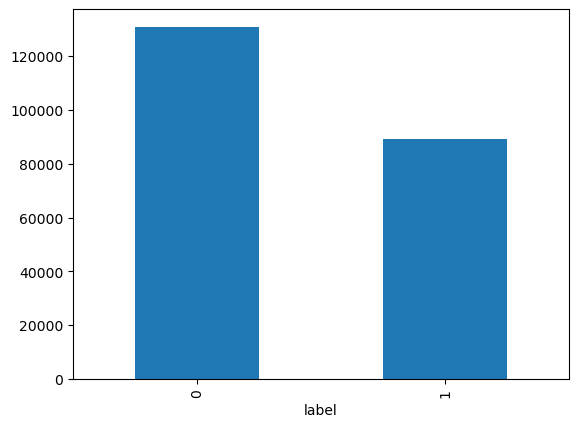

In [29]:
data['label'].value_counts().plot(kind='bar')
plt.show()


* Visualize Data

In [32]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

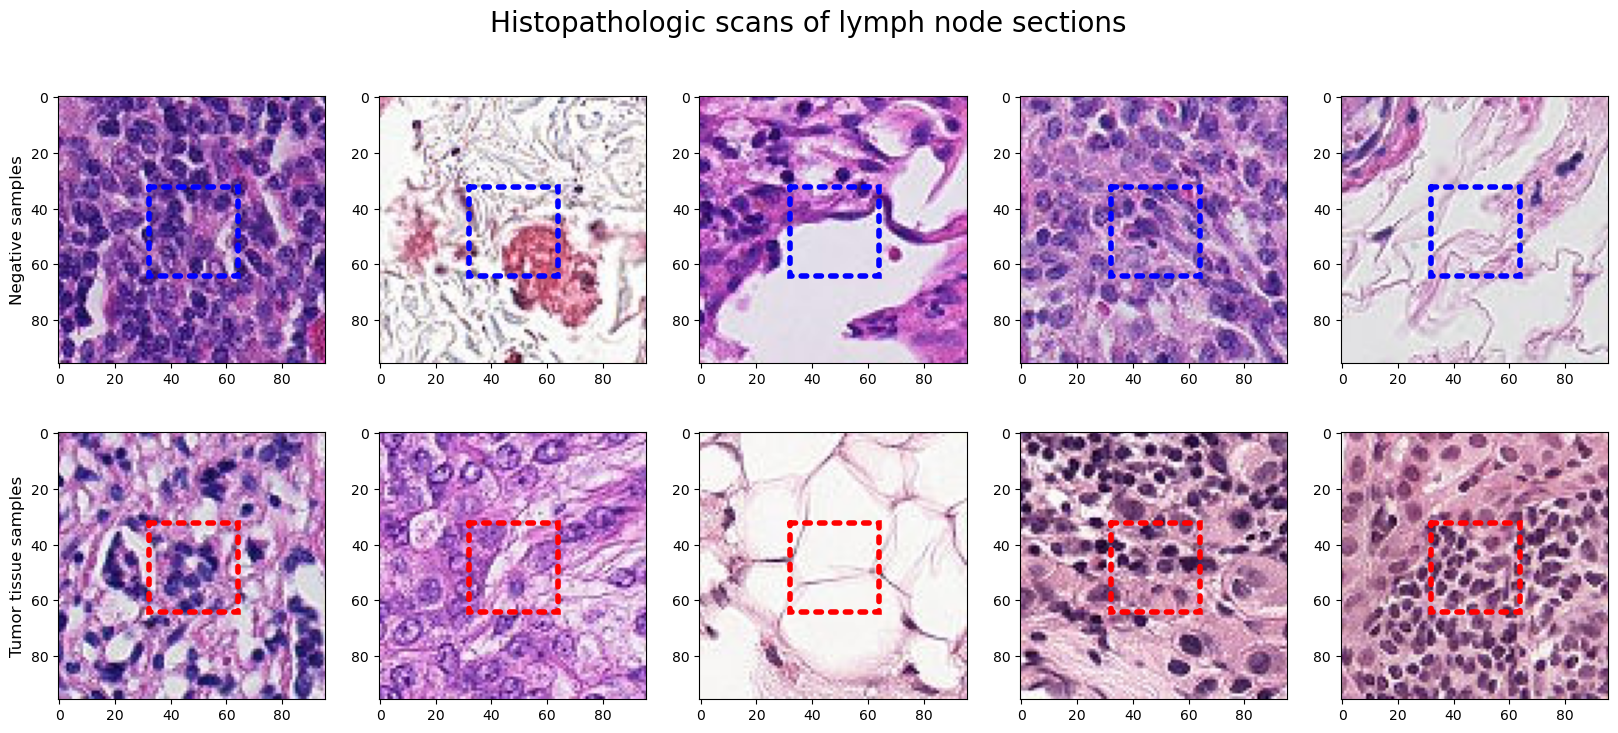

In [34]:
# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

# Balance Data (Down Sampling)
we have an imbalanced dataset (significantly more images of healthy tissue (130k) than cancerous tissue(89k), downsampling can help by reducing the majority class to match the size of the minority class.

In [37]:
data_0=data[data["label"] == 0].sample(89117, random_state=42)

In [39]:
data_1=data[data["label"] == 1]

In [41]:
df=pd.concat([data_0,data_1])

In [43]:
df['label'].value_counts()

label
0    89117
1    89117
Name: count, dtype: int64

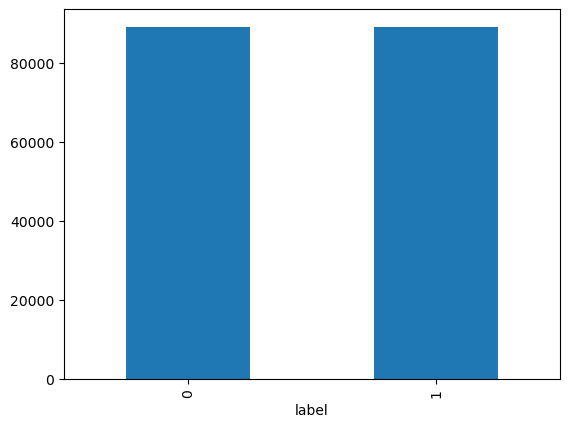

In [45]:
df['label'].value_counts().plot(kind='bar')
plt.show()


In [47]:
df

,id,label
121450,941ffe73059292e0effd4e81ca9363c117afc2f4,0
38268,43b6acadb31161c9281460efa3fad0b992a92837,0
158080,64cfb56ddf41e2a871ac5164d61e50b238b9ed1b,0
154803,9464cf403653088420cdb78acacd8cf7fa2255e4,0
93791,346bc5b2d383d70dfccb8fe9102c7f55687f5f52,0
...,...,...
220010,8a25b1632a1859d7b757e912ca673385b64e1b1d,1
220012,3e24dd48c3a419f4d669cac3cf71e777ba100541,1
220014,309210db7f424edbc22b2d13bf2fa27518b18f5c,1
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1


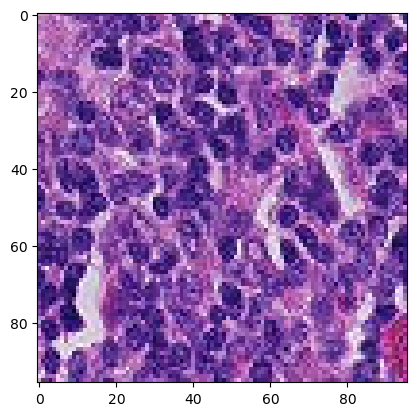

In [49]:
import matplotlib.pyplot as plt
import os


image_id = shuffled_data['id'].iloc[0]  # Get the first image ID
image_path = os.path.join(train_path, f'{image_id}.tif')

if os.path.exists(image_path):
    img = readImage(image_path)
    plt.imshow(img)
    plt.axis('on')
    plt.show()
else:
    print(f"Image file not found: {image_path}")

In [51]:
img.shape


(96, 96, 3)

**Preprocessing and augmentation**\
we are going to use minimal augmentations to enhance variability without overburdening computational resources, as we have a very big database (89k*2)\
for the augmentation : \
* Rotation: ±10° to account for slight orientation changes.
* Zooming: ±10% to simulate varying scan distances.
* Horizontal Flipping: To introduce left-right symmetry (if applicable).
* Brightness Adjustment: To handle lighting variations.

In [76]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


images_dir = train_path

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=10,        # Rotate images up to ±10 degrees
    zoom_range=0.1,           # Zoom in/out by 10%
    horizontal_flip=True,     # Flip images horizontally
    brightness_range=[0.8, 1.2]  # Adjust brightness
)

# Define a simple rescale-only generator for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Convert the labels to strings ('0' or '1')
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
train_df['id'] = train_df['id'].apply(lambda x: x + '.tif')
val_df['id'] = val_df['id'].apply(lambda x: x + '.tif')
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=images_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=images_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=32
)




Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


# 3. Prepare Data for training

* Prepare the data and split train

In [78]:
img.shape

(96, 96, 3)

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_efficient_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Fourth Conv Block (bottleneck)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Global Average Pooling to reduce the number of parameters
        GlobalAveragePooling2D(),

        # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
cnn_model = create_efficient_cnn_model()

# Model summary to check the parameters
cnn_model.summary()



C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 96, 96, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
cnn_model.fit(train_generator(), steps_per_epoch=len(df) // 32, epochs=10)

Epoch 1/10
 133/5569 ━━━━━━━━━━━━━━━━━━━━ 2:00:02 1s/step - accuracy: 0.9665 - loss: 0.0642

KeyboardInterrupt: 

## Test other batch_size and epochs

In [62]:
cnn_model.fit(train_generator(), steps_per_epoch=len(df) // 32, epochs=5)  # Using 5 epochs for faster testing


Epoch 1/5
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 2215s 396ms/step - accuracy: 0.9988 - loss: 0.0024
Epoch 2/5
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 2408s 432ms/step - accuracy: 1.0000 - loss: 2.0771e-07
Epoch 3/5
4384/5569 ━━━━━━━━━━━━━━━━━━━━ 7:47 395ms/step - accuracy: 1.0000 - loss: 4.2073e-05

KeyboardInterrupt: 

In [ ]:
#overfitting Issue so change the data generator and fir model again

In [82]:
# Fit the model
history=cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3889s 871ms/step - accuracy: 0.7993 - loss: 0.4499 - val_accuracy: 0.7674 - val_loss: 0.6226
Epoch 2/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5


C:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3940s 884ms/step - accuracy: 0.8756 - loss: 0.3014 - val_accuracy: 0.8546 - val_loss: 0.3778
Epoch 4/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3747s 841ms/step - accuracy: 0.8991 - loss: 0.2514 - val_accuracy: 0.7890 - val_loss: 0.4706


In [86]:
d_test=pd.read_csv('sample_submission.csv')
# Assuming you have a validation generator
validation_generator = load_and_augment_images(d_test, test_path)

# Evaluate the model on the validation set
loss, accuracy = cnn_model.evaluate(validation_generator(), steps=len(df) // 32)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 1015s 182ms/step - accuracy: 0.7858 - loss: 0.9076
Validation Loss: 0.9078983664512634
Validation Accuracy: 0.7863003015518188


In [89]:
# Save the trained model to a file
cnn_model.save('cnn_model.h5')  # Saves the model as a .h5 file


In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
# Retrieve true labels
y_true = val_generator.classes  # True labels from the generator
y_pred_probs = cnn_model.predict(val_generator, verbose=1)

# Get predicted classes (assuming binary classification)
y_pred = (y_pred_probs > 0.5).astype(int)




1114/1114 ━━━━━━━━━━━━━━━━━━━━ 328s 294ms/step


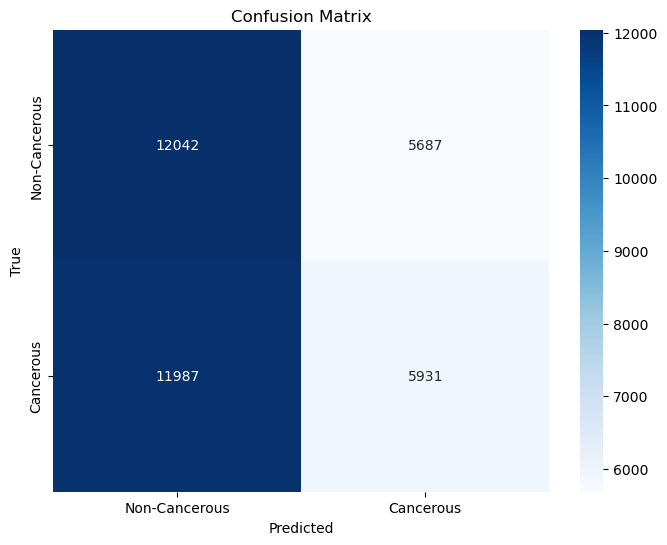

In [120]:
from sklearn.metrics import confusion_matrix
# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancerous", "Cancerous"], yticklabels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Model 2 : VGG16

In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_vgg16_model(input_shape=(96, 96, 3)):
    # Load the VGG16 model pre-trained on ImageNet without the top layer (fully connected layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16 to avoid training them
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),  # Adding a dense layer with 256 units
        Dropout(0.5),  # Dropout for regularization
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the VGG16-based model
vgg16_model = create_vgg16_model()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 40s 1us/step


In [93]:
# Train the model using the train_generator
vgg16_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator))


Epoch 1/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 7058s 2s/step - accuracy: 0.7984 - loss: 0.4367 - val_accuracy: 0.8359 - val_loss: 0.3670
Epoch 2/5


C:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


4456/4456 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 7509s 2s/step - accuracy: 0.8256 - loss: 0.3885 - val_accuracy: 0.8404 - val_loss: 0.3551
Epoch 4/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 7910s 2s/step - accuracy: 0.8337 - loss: 0.3728 - val_accuracy: 0.8475 - val_loss: 0.3413


In [122]:
d_test=pd.read_csv('sample_submission.csv')
# Assuming you have a validation generator

# Evaluate the model on the validation set
loss, accuracy = vgg16_model.evaluate(val_generator, steps=len(df) // 32)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


5569/5569 ━━━━━━━━━━━━━━━━━━━━ 1273s 228ms/step - accuracy: 0.8476 - loss: 0.3415
Validation Loss: 0.3413194417953491
Validation Accuracy: 0.8475327491760254


C:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [102]:
# Save the trained model
vgg16_model.save('vgg16_cnn_model.h5')


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 1542s 1s/step


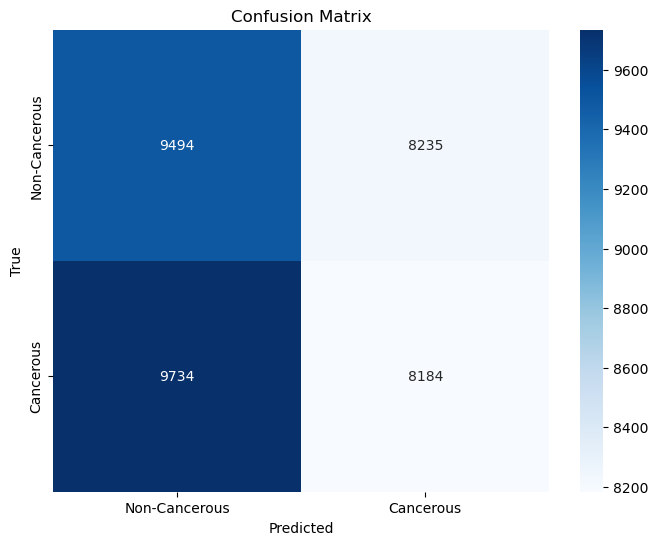

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
# Retrieve true labels
y_true = val_generator.classes  # True labels from the generator
y_pred_probs = vgg16_model.predict(val_generator, verbose=1)

# Get predicted classes (assuming binary classification)
y_pred = (y_pred_probs > 0.5).astype(int)


from sklearn.metrics import confusion_matrix
# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancerous", "Cancerous"], yticklabels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Model 3: EfficientNetB0

In [188]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # Freeze the base model initially

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # Add L2 regularization
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15, 
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3375s 753ms/step - accuracy: 0.5008 - loss: 1.2363 - val_accuracy: 0.5027 - val_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 2/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3330s 747ms/step - accuracy: 0.5039 - loss: 0.6936 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 3/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3283s 737ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 4/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3290s 738ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 5/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3996s 897ms/step - accuracy: 0.5012 - loss: 0.6931 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 1.0000e-04
Epoch 6/15
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3173s 712ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932 - learning_rate: 1.0000e-05
Epoch 7/15
4456/4456 ━

In [128]:

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator))


Epoch 1/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 2895s 643ms/step - accuracy: 0.4975 - loss: 0.6954 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 2/5


C:\Users\LENOVO\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


4456/4456 ━━━━━━━━━━━━━━━━━━━━ 1s 155us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3107s 697ms/step - accuracy: 0.5032 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932
Epoch 4/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 1s 158us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
4456/4456 ━━━━━━━━━━━━━━━━━━━━ 3061s 687ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.4973 - val_loss: 0.6932


In [ ]:
d_test=pd.read_csv('sample_submission.csv')
# Assuming you have a validation generator

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_generator, steps=len(df) // 32)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


 175/5569 ━━━━━━━━━━━━━━━━━━━━ 27:07 302ms/step - accuracy: 0.4996 - loss: 0.6931

In [179]:
# Save the trained model
model.save('EfficientNet_model.h5')


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 342s 307ms/step


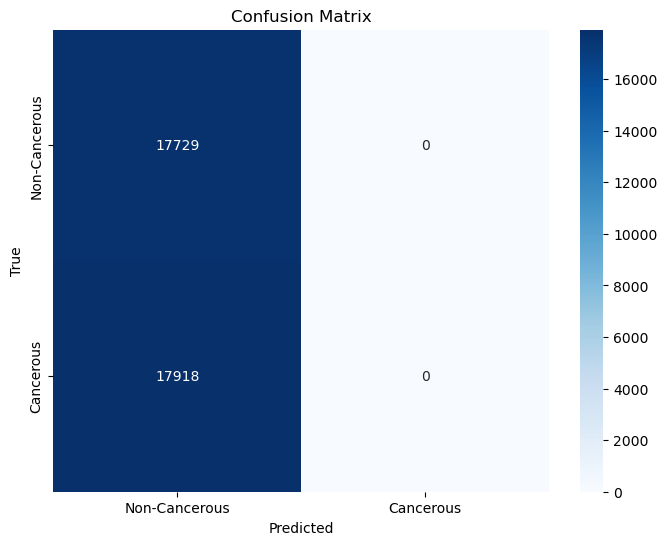

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
# Retrieve true labels
y_true = val_generator.classes  # True labels from the generator
y_pred_probs = model.predict(val_generator, verbose=1)

# Get predicted classes (assuming binary classification)
y_pred = (y_pred_probs > 0.5).astype(int)


from sklearn.metrics import confusion_matrix
# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Cancerous", "Cancerous"], yticklabels=["Non-Cancerous", "Cancerous"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()